<a href="https://colab.research.google.com/github/beifa/ML-models/blob/master/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM


### Make data

In [0]:
X1, y1 = make_moons(n_samples=150, noise=0.5, random_state=13)
X2, y2 = make_blobs(n_samples= 20, n_features=2, centers=1, center_box=[-2, -2], random_state=13)

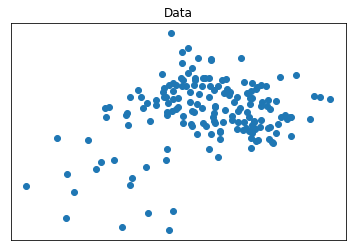

In [0]:
X = np.concatenate((X1, X2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
plt.scatter(X[:, 0],X[:, 1])
plt.title('Data')
plt.xticks(())
plt.yticks(());

### Gaussian distribution

Гауссово распределение
Чтобы выполнить обнаружение аномалий, вам сначала нужно будет подогнать модель к распределению данных. Учитывая обучающий набор {x (1),…, x (m)}
(где x (i) ∈Rn), вы хотите оценить распределение Гаусса для каждого из признаков xi.


The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

To estimate the mean, you will use: 
$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$
and for the variance you will use:
$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

In [0]:
def Gaussian(X, mu, sigma):
    """
    Gaussian distribution.

    Param:
    ------
    X : data
    mu : array_like, mean
    Sigma2 : var
    Returns
    ------
    p : probabilities each examples.
    """
    k = len(mu)
    X = X - mu
    """
    sigma.ndim == 1 return eerror
    add np.diag: 
               array([[1.18952268, 0.        ],
                      [0.        , 1.00437494]])

    """
    if sigma.ndim == 1:
        sigma2 = np.diag(sigma)

    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(sigma2) ** (-0.5)\
        * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2)) * X, axis=1))
    return p

In [0]:
mu = X.mean(axis = 0)
sigma = X.var(axis = 0)
gauss = Gaussian(X, mu, sigma)#find distr for each example

In [0]:
def vis_contour(X, mu, sigma):
    """
    Visualize the dataset and its estimated distribution
    Param:
    ------
    X : data
    mu : mean
    Sigma2 : var
    """
    X1, X2 = np.meshgrid(np.linspace(-4, 4, 150), np.linspace(-4, 4, 150))
    Z = Gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma)
    Z = Z.reshape(X1.shape)
    plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)
    plt.contour(X1, X2, Z, levels =10**(np.arange(-2., 2, 1)), linewidths=2, colors='k')
    plt.title('Visualize distribution')
    plt.xticks(())
    plt.yticks(());

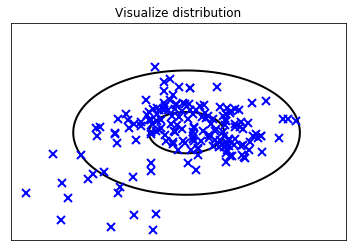

In [0]:
vis_contour(X, mu, sigma)

### Threshold
We need to find a threshold that tells us the anomaly or not

У нас есть примеры с высокой вероятностью и примеры с низкой вероятностью.
Примерами низкой вероятности, скорее всего, являются аномалии.
Один из способов определить, какие примеры являются аномалиями, - это выбрать порог на основе набора перекрестной проверки.

Нам нужно найти порог ε. Если пример x имеет низкую вероятность p (x) < ε, то он считается аномалией.

Нужно реализовать F1, которая говорит вам, насколько хорошо вы справляетесь с поиском аномалий при заданном пороговом значении.

F1, сколько примеров правильно и неправильно классифицирует текущий порог.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

You compute precision and recall by: 

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

where: 

- $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

-  $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
mu = X.mean(axis = 0)
sigma = X.var(axis = 0)
gauss = Gaussian(X, mu, sigma)#find distr for each example

In [0]:
def threshold(y_test, gauss_test):  
  best_eps = 0
  best_f1 = 0
  F1 = 0
  for epsilon in np.linspace(min(gauss_test),  max(gauss_test), 1000):
    pred = epsilon > gauss_test
    tp = np.sum((pred == 1) & (y_test == 1))
    fp = np.sum((pred == 0) & (y_test == 1))
    fn = np.sum((pred == 1) & (y_test == 0))
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)    
    F1 = (2 * prec * rec) / (prec + rec)    
    if F1 > best_f1:
      best_f1 = F1
      best_eps = epsilon    
  return best_f1, best_eps

In [0]:
gauss_test = Gaussian(X_test, mu, sigma)
best_f1, best_eps = threshold(y_test, gauss_test)
best_eps, best_f1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


(0.10149426586178338, 0.5909090909090909)

In [0]:
"""
как я думаю при  границе в 0.1 F1score = 0.59
получается что внутри границы .6 точьность
"""
outliers = gauss < 0.10

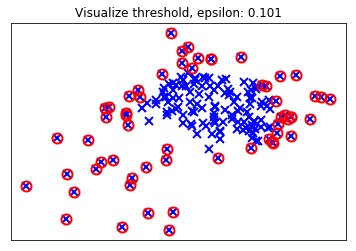

In [0]:
plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
plt.title('Visualize threshold, epsilon: '+ str(np.round(best_eps, decimals=3)))
plt.xticks(())
plt.yticks(());

### Test sklearn

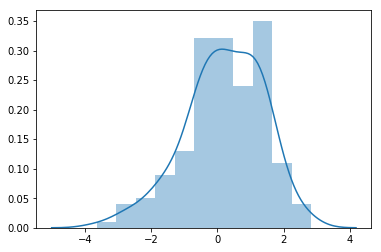

In [0]:
sns.distplot(X[:, 0]);

#### EllipticEnvelope

In [0]:
cov = EllipticEnvelope(contamination=.1,random_state=0).fit(X)
pred = cov.predict(X)

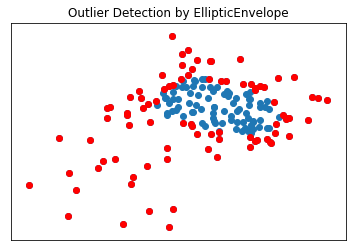

In [0]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X[pred < 0][:, 0], X[pred < 0][:, 1], c = 'r')
plt.title('Outlier Detection by EllipticEnvelope')
plt.xticks(())
plt.yticks(());

#### OneClassSVM

In [0]:
one = OneClassSVM(random_state=0).fit(X)
pred = one.predict(X)

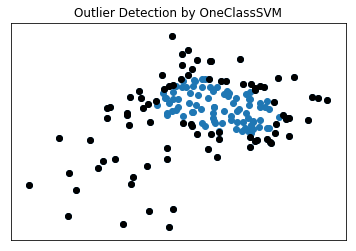

In [0]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X[pred < 0][:, 0], X[pred < 0][:, 1], c = 'k')
plt.title('Outlier Detection by OneClassSVM')
plt.xticks(())
plt.yticks(());